# Normalizing Flows
## A short stroll from discrete to continuous time
<br><br>
## Aalto University, EEA
Adrien Corenflos, 2.11.2020

# Outline

1. Generative models

2. Problem formulation

3. Discrete time normalizing flows

4. Continuous time normalizing flows

# Generative models

## Definition

Statistical models are usually divided in two classes: discriminative and generative <cite>[1, Ch.2]</cite>.

- discriminative:<br>
    Discriminative models are a class of statistical models encode the conditional distribution of the observation given the input
    $$
    \begin{equation}
        \mathbb{P}(Y \mid X)
    \end{equation}
    $$
    


- generative:<br>
    Generative models on the other end encode the joint distribution of the input and the observation
    $$
    \begin{equation}
        \mathbb{P}(X, Y)
    \end{equation}
    $$

## Some examples:

| Discriminative | Generative |
| --- | --- |
| Logistic regression | Naive Bayes classifier |
| Support vector machines | Gaussian Processes |
| Decision trees | Bayesian Networks | 
| Neural Networks | ? |

# Problem formulation

## The data generation problem

We will consider the two following problems:


1. Given a series of observations $Y_n$'s, how do we calibrate a probabilistic model that is able to generate "similar" data?
    For example, how can we generate handwritten numbers:

In [1]:
from sklearn.datasets import fetch_openml
mnist_X, mnist_y = fetch_openml('mnist_784', version=1, return_X_y=True)

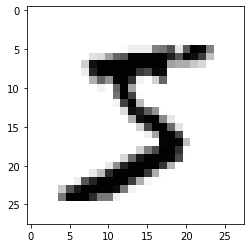

In [2]:
import matplotlib.pyplot as plt
_ = plt.imshow(1 - mnist_X[0].reshape(28, 28), cmap="gray")

2. Given a complicated likelihood function how do we sample from it? For example:

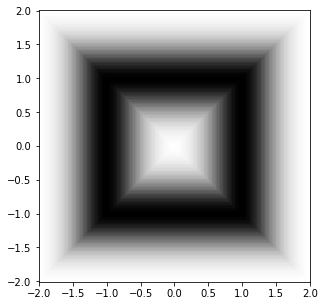

In [3]:
import numpy as np

def square(x, y):
    abs_x = np.abs(x)
    abs_y = np.abs(y)
    return 0.25 * np.exp(-4*(np.maximum(abs_x, abs_y) - 1) ** 2) / np.sqrt(np.pi)

def plot_square(ax=None):
    linspace = np.linspace(-2., 2., 200)
    mesh_x, mesh_y = np.meshgrid(linspace, linspace)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_aspect("equal")
    _ = ax.pcolormesh(mesh_x, mesh_y, 1. - square(mesh_x, mesh_y), cmap="gray", shading='auto')

plot_square()

## Non exhaustive solutions

1. Data registration:  
    a. Variational auto-encoders  
    b. Generative adversarial networks  
    c. Normalizing flows

2. Distribution sampling:  
    a. MCMC  
    b. Normalizing flows

1.a. VAE  
    Learn a latent representation of the distribution 
    ![image-4.png](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

Image from Wikimedia. To go further see [2].

1.b. GAN  
    Learn to fool a expert networks, or more recently learn to minimize Wasserstein distance between true and generated. 
    $$\underset{\theta}{\min} \mathcal{W}\bigg(G_\theta, [Y_n]_{n=1}^N\bigg)$$
    
To go further see [3].

2.a. MCMC  
    Acceptance-rejection method for exact sampling. 

In [4]:
def mh(f, n=1000, seed=0):
    rng = np.random.RandomState(seed)
    arr = np.empty((n, 2))
    x, y = rng.uniform(-1, 1, 2)
    p = f(x, y)
    for i in range(n):
        eps_x, eps_y = rng.uniform(-1, 1, 2)
        xi, yi = x + eps_x, y + eps_y
        pi = f(xi, yi)
        if rng.rand() <= pi / p:
            x, y = xi, yi
            p = pi
        arr[i] = x, y
    return arr

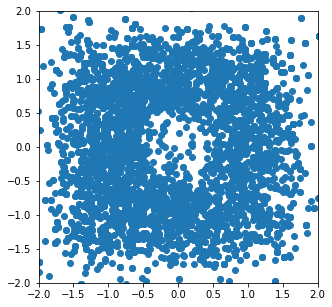

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-2, 2), ax.set_ylim(-2, 2)
_ = ax.scatter(*mh(square, 5000).T)

# Discrete time normalizing flows

## Principle
- Flow: stands for composition
- Normalizing: stands for the fact that each transformation is normalizing: keeps total probability mass constant

$$
\begin{align}
    X_0 &\sim U([0, 1]^d) \quad \text{or} \quad \mathcal{N}(0, I_d) \\
    X_i &= f_i(X_{i-1}, \theta_i)
\end{align}
$$

Normalizing means that $f_i$ needs to be bijective.

## Change of variable

Let $Z = f(X)$,
$$p_Z(z) = p_X(f^{-1}(z)) \cdot \mathrm{d}V(f^{-1}(z))$$
where $dV$ is local the change of volume incurred by the change of variable.

Lebesgue theory tells us that 
$$\mathrm{d}V = \left| \mathrm{det}J_f^{-1}\right| = \left| \mathrm{det}J_f\right|^{-1}$$

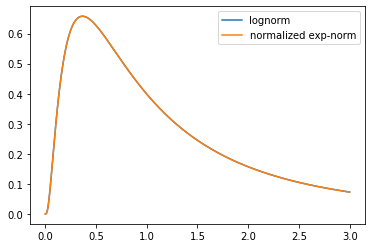

In [6]:
import scipy.stats as st

def f(x): return np.exp(x)
def dV(z): return 1/z

linspace = np.linspace(1e-3, 3., 10000)
_ = plt.plot(linspace, st.lognorm.pdf(s=1., x=linspace), label="lognorm")
_ = plt.plot(linspace, st.norm.pdf(x=np.log(linspace)) * dV(linspace), label="normalized exp-norm")
_ = plt.legend()

## Flows  and chain rule

So now the composed model reads:
$$
\begin{align}
    Z = X_n = f_n(f_{n-1}(\dots, \theta_{n-1}), \theta_n))
\end{align}
$$

so that $p_Z(z) = p_X(x) \prod_{i=1}^n \left|\mathrm{det}J_{f_i}^{-1}\right|$, or said otherwise:
$$
\ln p_Z(z) = \ln p_X(x) - \sum_{i=1}^n \ln \left|\mathrm{det}J_{f_i}\right|
$$
for which we want to compute the gradient with respect to $\theta = [\theta_n, \dots, \theta_1]$

So how do we compute $\frac{\partial}{\partial \theta_i} \ln \left|\mathrm{det}J_{f_i}\right|$ ? 

$$ \mathrm{d}(\ln\left| \mathrm{det}(M)\right|) = M^{-\top}\mathrm{d}M$$
So that we need to invert all the $J_{f_i}$: ($O(N^3)$)!!!

This restricts the practical form of the $f_i$'s quite a bit to functions for which the log-determinant of the Jacobian has an easy to compute form: triangular Jacobian, or...

## Planar flows [4]


$$
\begin{align}
    f(\mathbf{x}, \mathbf{a}, b, \mathbf{w}) = \mathbf{x} + \sigma(\mathbf{w}^\top \cdot \mathbf{x} + b) \mathbf{a}
\end{align}
$$

$$
\begin{align}
    J_f = I + \sigma'(\mathbf{w}^\top \cdot \mathbf{x} + b) \mathbf{a} \cdot \mathbf{w}^\top
\end{align}
$$

for which, using the [Matrix determinant lemma](https://en.wikipedia.org/wiki/Matrix_determinant_lemma), we get

$$
\begin{align}
    \mathrm{det}(J_f)= 1 + \sigma'(\mathbf{w}^\top \cdot \mathbf{x} + b) \cdot \mathbf{a}^\top \cdot \mathbf{w}
\end{align}
$$

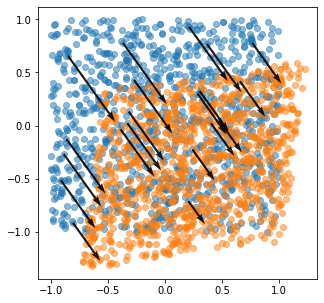

In [7]:
def sigmoid(y): return 1 / (1 + np.exp(-y)) 
def planar_flow_sigmoid(x, a, b, w): return x + sigmoid(x @ w + b).reshape(-1, 1) * a.reshape(1, -1)

uniform = np.random.uniform(-1, 1, (1000, 2))
a, b, w = np.array([0.5, -0.75]), 0., np.array([-1, 1])
transformed_uniform = planar_flow_sigmoid(uniform, a, b, w)

fig, ax = plt.subplots(figsize=(5, 5),)
_ = ax.scatter(*uniform.T, alpha=0.5)
_ = ax.scatter(*transformed_uniform.T, alpha=0.5)
_ = ax.quiver(*uniform[:20].T, *(transformed_uniform[:20].T - uniform[:20].T), 
              units='xy', angles="xy", scale=1, alpha=0.9)

## MLE vs KL divergence
Does it mean we can compute the log-likelihood of a sample? 

Well no (see [5] for a model where you can and it's efficient). To do this you need to compute $f^{-1}(y)$.
So instead we need to go forward: KL divergence!

$$
\begin{align}
    \textrm{KL}(q \mid\mid u) 
        &= \int p \ln \frac p q\\
        &\approx \frac 1 N \sum_{i=1} \left(\ln f_0(u_i) - \sum_{i=1}^K \ln \left|\mathrm{det}J_{f_i}\right| - \ln p(z_i) \right)
\end{align}
$$

In [8]:
import tensorflow as tf
import tensorflow_probability as tfp

@tf.function
def tf_planar_flow(x, a, b, w, sigma): 
    scale = sigma(tf.linalg.matvec(x, w) + b)
    return x + tf.reshape(scale, (-1, 1)) * tf.reshape(a, (1, -1))

@tf.function
def tf_planar_log_det_jac(x, a, b, w, sigma):
    z = tf.linalg.matvec(x, w) + b
    with tf.GradientTape() as tape:
        tape.watch(z)
        val = sigma(z)
    scalar_prod = tf.tensordot(a, w, 1)
    sigma_prime = tape.gradient(val, z)
    return tf.math.log(tf.math.abs(1. + scalar_prod * sigma_prime))

@tf.function
def kl_planar(a_list, b_list, w_list, sigma, p, N, d, key):
    # without the initial distribution
    
    def fun(u, v):
        (f_k, log_det_jac), (a, b, w) = u, v
        return (tf_planar_flow(f_k, a, b, w, sigma),
                tf_planar_log_det_jac(f_k, a, b, w, sigma))
    
    us = tf.random.stateless_uniform((N, d), key, 0, 1)
    xks, log_det_jacs = tf.scan(fun, [a_list, b_list, w_list], (us, tf.zeros((us.shape[0],), dtype=us.dtype)))
    pus = p(xks[-1])
    logp = tf.math.log(pus)
    kl_val = -logp - tf.reduce_sum(log_det_jacs, axis=0)
    return tf.math.reduce_mean(kl_val), xks[-1]

In [9]:
@tf.function
def tf_square(z):
    abs_x = tf.math.abs(z[:, 0])
    abs_y = tf.math.abs(z[:, 1])
    return 0.25 * tf.exp(-4.*(tf.math.maximum(abs_x, abs_y) - 1.) ** 2) / tf.math.sqrt(np.pi)

In [10]:
tf_sigmoid = tf.function(tf.math.sigmoid)

In [11]:
N = 5000
K = 5
n_iter = 1000
learning_rate = 0.1
decay = 0.95
keys = tfp.random.split_seed(42, n=n_iter + 3)

a_vars = tf.random.stateless_normal((K, 2), keys[0])
w_vars = tf.random.stateless_normal((K, 2), keys[1])
b_vars = tf.random.stateless_normal((K,), keys[2])

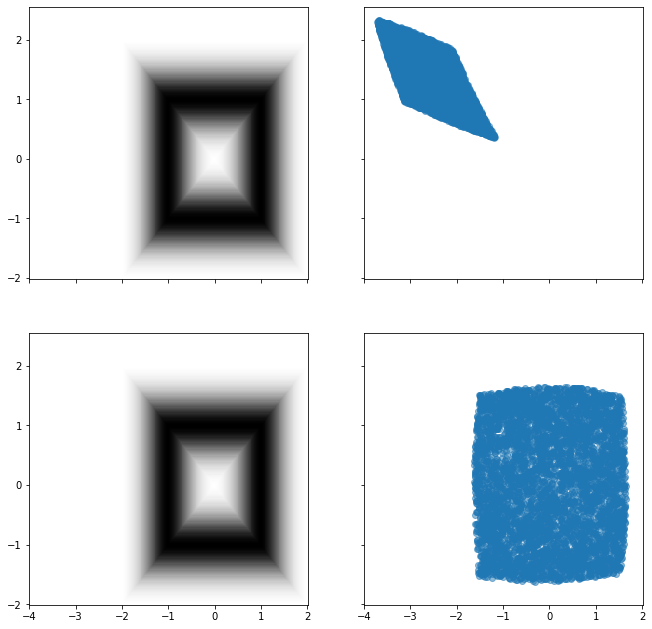

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11, 11), sharex=True, sharey=True)
plot_square(axes[0, 0])

lr = learning_rate
for i in range(n_iter):
    with tf.GradientTape() as tape:
        tape.watch([a_vars, b_vars, w_vars])
        loss, sample = kl_planar(a_vars, 
                                 b_vars, 
                                 w_vars,
                                 tf_sigmoid,
                                 tf_square,
                                 N,
                                 2,
                                 keys[i+3])
    if i == 0:
        axes[0, 1].scatter(*sample.numpy().T, alpha=0.5)
    grad_a, grad_b, grad_w = tape.gradient(loss, [a_vars, b_vars, w_vars])
    a_vars = a_vars - learning_rate * grad_a
    b_vars = b_vars - learning_rate * grad_b
    w_vars = w_vars - learning_rate * grad_w
    lr = lr * decay 


axes[1, 1].scatter(*sample.numpy().T, alpha=0.5)
plot_square(axes[1, 0])


# Continuous time normalizing flows [6]

## Principle

Let's have a further look at the recursion induced by the planar flow:

$$
\begin{align}
    x_k 
        &= x_{k-1} + f_{\theta_k}(x_{k-1})\\
    (x_k - x_{k-1})
        &= g(k, x_{k-1}, \theta_k) \Delta
\end{align}
$$


So that if $\Delta \to 0$, we can recognize an Euler discretization scheme for 
$$
\begin{align}
    \mathrm{d}x_t &= f(x_t, x, t, \theta) \mathrm{d}t \\
    x_0 &\sim p_0
\end{align}
$$

## Why is it interesting?

- Invertibility guarantees
- Easy to compute change of variable scaling
- Gradient calculation happens to be easy

### Invertibility guarantees

Cauchy theorem: as long as $f$ is continuous, the trajectories are uniquely defined by their starting point (or any point for that matter).
Moreover, if we let $y_s = x_{t-s}$, then 

$$
\begin{align}
    y_s' = f(y_s)
\end{align}
$$

### Change of variables scaling

We have 

$$
\begin{align}
    \frac{\partial}{\partial t} \ln p_{t}(x_t) = - \mathrm{Tr}\left(J_x[f](x_t)\right)
\end{align}
$$

so that to compute the log-likelihood, you only need to augment the state

In [13]:
def ode_fun(t, z, fun, fun_params):
    x, logp = z[..., :-1], z[..., -1]
    with tf.GradientTape() as tape:
        tape.watch(x)
        drift = fun(t, x, *fun_params)
    jac_drift = tape.batch_jacobian(drift, x)
    return tf.concat([drift, 
                      tf.expand_dims(tf.linalg.trace(jac_drift), 1)], axis=-1)

For instance consider a linear system
$\mathrm{d}x_t = A x_t$

In [14]:
@tf.function
def linear_fun(t, x, a):
    return tf.matmul(x, a, transpose_b=True)

key = tfp.random.split_seed(666, n=1)
N = 1000
D = 2
A = 0.5 * tf.eye(D)
t0, t1 = 0., 1.
x0_dist = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(D))
x0 = x0_dist.sample(N)
x0 = tf.concat([x0,
                tf.expand_dims(x0_dist.log_prob(x0), 1)], axis=1) # the log-likelihood

@tf.function
def linear_ode_fun(t, x, a):
    return ode_fun(t, x, linear_fun, [a])

res = tfp.math.ode.DormandPrince().solve(linear_ode_fun, 
                                         t0, x0, solution_times=[t1],
                                         constants={'a': A}, 
                                         batch_ndims=0).states.numpy()

<ipython-input-15-f04440bd6476>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(m_x, m_y, st.multivariate_normal.pdf(grid, cov=expm(2 * A.numpy())))
<ipython-input-15-f04440bd6476>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(m_x, m_y, ode_pdf.reshape(100, 100))


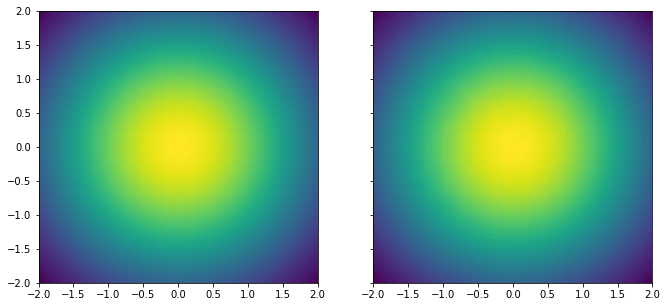

In [15]:
from scipy.linalg import expm
from scipy.interpolate import griddata

m_x, m_y = np.meshgrid(np.linspace(-2, 2, 100),
                       np.linspace(-2, 2, 100))
ode_pdf = griddata(res[-1, :, :-1], np.exp(res[-1, :, -1]), (m_x, m_y), method='linear')

grid = np.stack([m_x, m_y], -1)

fig, axes = plt.subplots(ncols=2, figsize=(11, 5), sharex=True, sharey=True)
_ = axes[0].pcolormesh(m_x, m_y, st.multivariate_normal.pdf(grid, cov=expm(2 * A.numpy())))
_ = axes[1].pcolormesh(m_x, m_y, ode_pdf.reshape(100, 100))

### Informal proof (original so pardon me if you see a mistake)
For a formal proof, please see [6]. Consider a discretization of the ODE

$$
\begin{align}
    x_{t+h} = x_t + h f(x_{t})
\end{align}
$$
Now using the discrete time change of variable,
$$
\ln p(x_{t+h}) = \ln p(x_{t}) - \ln |\mathrm{det}(I + hJ_f)|
$$
Now in $\mathrm{det}(I + hJ_f)$ we recognize the characteristic polynomial of $J_f$:
$$
\begin{align}
\mathrm{det}(I + hJ_f) 
    &= h^n \left (h^{-n} + h^{-n+1}Tr(J_f) + \dots \right)\\
    &= \left (1 + hTr(J_f) + \dots \right)\\
\end{align}
$$
and 
$$
\ln(1 + hTr(J_f) + \dots) = h Tr(J_f) + o(h)
$$

### Gradient calculation

Now the question becomes: how do we compute the dependency of $−\mathrm{Tr}(𝐽_𝑥[𝑓](𝑥𝑡))$  with respect to its parameter $\theta$?

This can be done using backward dynamics by considering ([6]):  
$$
\begin{align}
    \frac{\mathrm{d}a(t)}{\mathrm{d}t}& = a(t)^\top J_x[f] \\
    \frac{\mathrm{d}\frac{\mathrm{d}\ell(t)}{\mathrm{d}\theta}}{\mathrm{d}t}& = a(t)^\top J_\theta[f]
\end{align}
$$

Note that it involves vector-Jacobian products only!
(I'm not going to code it, it's plainly painful to do this in a notebook, but the [tensorflow_probability code](https://github.com/tensorflow/probability/blob/bf84eb67f342e332b7c09b8f435ba534cd91725e/tensorflow_probability/python/math/ode/base.py#L315) is pretty clean!)

In [16]:
with tf.GradientTape() as tape:
    tape.watch(A)
    res = tfp.math.ode.DormandPrince().solve(linear_ode_fun, 
                                             t0, x0, solution_times=[t1],
                                             constants={'a': A}, 
                                             batch_ndims=0)
    loss = tf.reduce_mean(res.states[-1, ..., -1])
tape.gradient(loss, A)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.000001, 0.      ],
       [0.      , 1.000001]], dtype=float32)>

### In practice:
In this small example we revisit our square example:

In [44]:
@tf.function
def tf_continuous_planar_flow(_t, x, a, b, w): 
    scale = tf_sigmoid(tf.linalg.matvec(x, w) + b)
    return tf.reshape(scale, (-1, 1)) * tf.reshape(a, (1, -1))

@tf.function
def planar_flow_ode_fun(t, x, a, b, w):
    return ode_fun(t, x, tf_continuous_planar_flow, [a, b, w])

In [49]:
N = 500
n_iter = 10
learning_rate = 0.1
decay = 0.95

keys = tfp.random.split_seed(31416, n=4)

a_ct = tf.random.stateless_normal((2,), keys[0])
w_ct = tf.random.stateless_normal((2,), keys[1])
b_ct = tf.random.stateless_normal((), keys[2])

x0 = tf.concat([tf.random.stateless_uniform((N, 2), keys[3], 0, 1),
                tf.zeros((N, 1))], axis=1)
dp = tfp.math.ode.DormandPrince()


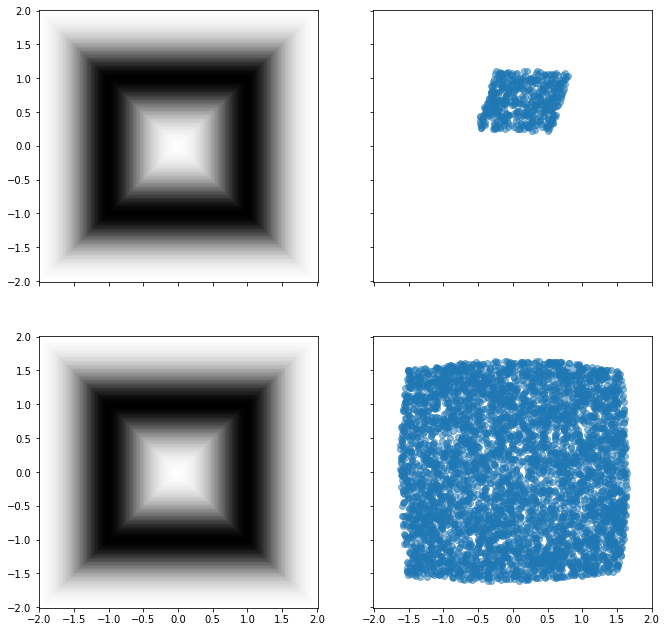

In [50]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11, 11), sharex=True, sharey=True)
plot_square(axes[0, 0])

lr = learning_rate
for i in range(n_iter):
    with tf.GradientTape() as tape:
        tape.watch([a_ct, b_ct, w_ct])
        res = dp.solve(planar_flow_ode_fun, 
                       0., x0, solution_times=[1.],
                       constants={'a': a_ct, 'b': b_ct, 'w': w_ct}, 
                       batch_ndims=0).states
        loss = tf.reduce_mean(res[-1, ..., -1] - tf.math.log(tf_square(res[-1, ..., :-1])))
        if i == 0:
            axes[0, 1].scatter(*res[-1, :, :2].numpy().T, alpha=0.5)
            
    grad_a, grad_b, grad_w = tape.gradient(loss, [a_ct, b_ct, w_ct])
    a_vars = a_vars - learning_rate * grad_a
    b_vars = b_vars - learning_rate * grad_b
    w_vars = w_vars - learning_rate * grad_w
    lr = lr * decay


axes[1, 1].scatter(*sample.numpy().T, alpha=0.5)
plot_square(axes[1, 0])

I didn't get a chance to show a proper likelihood fitting, but it should't be too hard using the code. In particular, one thing I would have liked to try out in this notebook would have been MCMC CNFs, but I ran out of time.

# To go further
- Augmented neural ODES [7]: some topologies cannot be representend by a bijective Neural-drift ODE. The authors show how to augment the state to improve sampling capabilities
- Continuous Normalizing Flows via Optimal Transport [8]: efficient path sampling. Many vector fields can lead to the same final distribution, the authors find the most efficient one in the sense of OT.
- Scalable Gradients for Stochastic Differential Equations [9]: what happens when you add a stochastic component? Note: there are a few subtle mistakes in the paper but their code is working.

# References

[1]: Jebara, Tony. Machine Learning: Discriminative and Generative, Springer US, 2004.  
[2]: Doersch, Carl. Tutorial on variational autoencoders, arXiv:1606.05908.  
[3]: Genevay, Aude and al. Learning Generative Models with Sinkhorn Divergences, AISTATS, 2018.  
[4]: Rezende, Danilo and Mohamed, Shakir. Variational Inference with Normalizing Flows, ICML, 2015.  
[5]: Papamakarios, George and al. Masked Autoregressive Flow for Density Estimation, NEURIPS, 2017.  
[6]: Chen, Ricky T. & al. Neural ordinary differential equations. NEURIPS, 2018. 
[7]: Dupont, Emilien & al. Augmented neural ODEs. NEURIPS, 2019.
[8]: Onken, Derek and al. OT-Flow: Fast and Accurate Continuous Normalizing Flows via Optimal Transport. ArXiv:2006.00104, 2020.
[9]: Li, Xuechen and al. Scalable Gradients for Stochastic Differential Equations. AISTATS, 2020.

In [ ]:
Papamakarios